##### $\hspace{15pt}$ **Filename: imageRecognitionOnCIFAR.ipynb**
##### $\hspace{1.5pt}$ **Date Created: January 7, 2024**
##### **Date Modified: January 17, 2024**
##### $\rule{10.5in}{1pt}$
##### **Train and test neural networks to recognize images in a subset of the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).**

##### **The content of this notebook is based on the discussion in sections 7.1 - 7.2 and 8.2 - 8.4 of the book [Deep Learning with Pytorch](https://www.manning.com/books/deep-learning-with-pytorch). Some changes were made in the presentation of the content particularly in the specific subset of images that was used for demonstration purposes.**
##### $\rule{10.5in}{1pt}$

##### Load modules and packages.

In [1]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

##### Set the seed of Pytorch random number generator.

In [2]:
torch.manual_seed(0)

##### Set the device where Pytorch operations will be performed.

In [3]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

##### Set the path to the folder where the datasets and the models will be saved.

In [4]:
path = "gdrive/MyDrive/Colab Notebooks/011_imageRecognitionOnCIFAR/"

##### Download datasets from CIFAR-10 train and test sets.

In [5]:
cifar10TrainSet = datasets.CIFAR10(path, train = True, download = True, transform = transforms.ToTensor())
cifar10TestSet = datasets.CIFAR10(path, train = False, download = True, transform = transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:13<00:00, 12646877.81it/s]


Extracting gdrive/MyDrive/Colab Notebooks/011_imageRecognitionOnCIFAR/cifar-10-python.tar.gz to gdrive/MyDrive/Colab Notebooks/011_imageRecognitionOnCIFAR/
Files already downloaded and verified


##### Stack along an extra dimension all the tensors in the train set.

In [6]:
stackedTensors = torch.stack([image for image, label in cifar10TrainSet], dim = 3)

##### Calculate the mean per channel.

In [7]:
channelMeans = stackedTensors.view(3, -1).mean(dim = 1)
channelMeans = tuple(channelMeans.tolist())
channelMeans

(0.4913996458053589, 0.48215845227241516, 0.44653093814849854)

##### Calculate the standard deviation per channel.

In [8]:
channelSDs = stackedTensors.view(3, -1).std(dim = 1)
channelSDs = tuple(channelSDs.tolist())
channelSDs

(0.24703224003314972, 0.24348513782024384, 0.26158785820007324)

##### Normalize the train and test sets.

In [9]:
cifar10TrainSet = datasets.CIFAR10(path, train = True, download = False,
                                   transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(channelMeans, channelSDs)]))
cifar10TestSet = datasets.CIFAR10(path, train = False, download = False,
                                  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(channelMeans, channelSDs)]))

##### Display a sample of cat images.

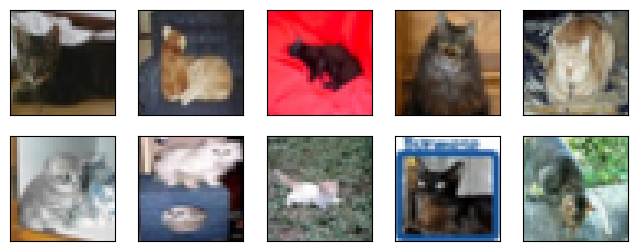

In [10]:
fig = plt.figure(figsize = (8, 3))

catImages = [image for image, label in datasets.CIFAR10(path, train = True, download = False) if label == 3]
for i in range(10):

    ax = fig.add_subplot(2, 5, 1 + i, xticks = [], yticks = [])
    plt.imshow(catImages[i])

plt.show()

##### Display a sample of dog images.

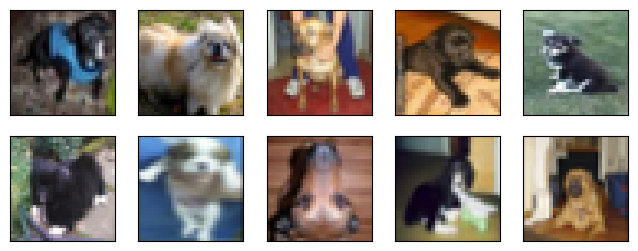

In [11]:
fig = plt.figure(figsize = (8, 3))

dogImages = [image for image, label in datasets.CIFAR10(path, train = True, download = False) if label == 5]
for i in range(10):

    ax = fig.add_subplot(2, 5, 1 + i, xticks = [], yticks = [])
    plt.imshow(dogImages[i])

plt.show()

##### Filter the train and test sets to get only the cat and dog images.

In [12]:
labelMap = {3: 0, 5: 1}
cifar2TrainSet = [(image, labelMap[label]) for image, label in cifar10TrainSet if label in [3, 5]]
cifar2TestSet = [(image, labelMap[label]) for image, label in cifar10TestSet if label in [3, 5]]

$\hspace{1in}$

##### **Fully Connected Neural Network**

##### Define a function that will be used to train and test a fully connected neural network.

In [13]:
def trainTestFCN(nEpochs, optimizer, model, loss, displayEpochs = True):
    "Train and test a fully connected neural network."

    startTime = time.time()

    print(f"Training and testing on a {device} device.")

    trainLossList = []
    testLossList = []
    for epoch in range(1, nEpochs + 1):

        for image, label in cifar2TrainSet:

            image = image.to(device = device)
            label = torch.tensor([label]).to(device = device)
            output = model(image.view(-1).unsqueeze(0))
            trainL = loss(output, label)

            optimizer.zero_grad()
            trainL.backward()
            optimizer.step()

        with torch.no_grad():

             for image, label in cifar2TestSet:

                 image = image.to(device = device)
                 label = torch.tensor([label]).to(device = device)
                 output = model(image.view(-1).unsqueeze(0))
                 testL = loss(output, label)
                 assert testL.requires_grad == False

        if displayEpochs:

           if epoch <= 3 or epoch >= nEpochs - 2:

              print('\n Epoch %d:' % epoch)
              print('    Training Loss = %f' % trainL)
              print('        Test Loss = %f' % testL)

           if epoch == 4:
              print('\n...\n...\n...\n')

        trainLossList.append(float(trainL))
        testLossList.append(float(testL))

    executionTime = time.time() - startTime

    if executionTime < 60:
       print("\n   Execution Time = %f seconds" % executionTime)
    else:
       print("\n   Execution Time = %f minutes" % (executionTime/60))

    return trainLossList, testLossList

##### Run the function using a fully connected neural network with an input layer of 3,072 neurons, a hidden layer of 512 neurons with a `Tanh` activation function, and an output layer of 2 neurons with a `LogSoftmax` activation function.

In [14]:
nEpochs = 100
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 2),
                      nn.LogSoftmax(dim = 1)).to(device = device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
loss = nn.NLLLoss()
trainLossList, testLossList = trainTestFCN(nEpochs = nEpochs, optimizer = optimizer, model = model, loss = loss)

Training and testing on a cuda device.

 Epoch 1:
    Training Loss = 4.854607
        Test Loss = 5.748781

 Epoch 2:
    Training Loss = 6.226524
        Test Loss = 4.330370

 Epoch 3:
    Training Loss = 0.626967
        Test Loss = 5.580410

...
...
...


 Epoch 98:
    Training Loss = 0.166585
        Test Loss = 8.302530

 Epoch 99:
    Training Loss = 0.026269
        Test Loss = 9.720849

 Epoch 100:
    Training Loss = 0.062725
        Test Loss = 10.604031

   Execution Time = 18.357575 minutes


##### Display how the values of the loss function change throughout the 100 epochs in the training set.

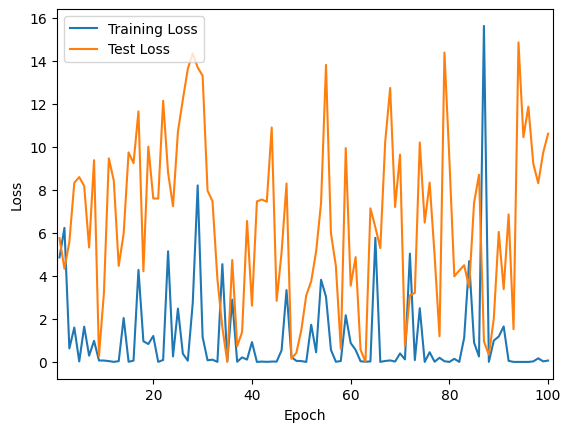

In [15]:
plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.plot(range(1, len(trainLossList) + 1), trainLossList)
plt.plot(range(1, len(testLossList) + 1), testLossList)
plt.xlim([0.5, nEpochs + 1])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Test Loss"], loc ="upper left")
plt.show()

##### List the number of parameters the model has in each of its layers.

In [16]:
numelList = [p.numel() for p in model.parameters() if p.requires_grad == True]
numelList

[1572864, 512, 1024, 2]

##### Count the total number of parameters the model has.

In [17]:
sum(numelList)

1574402

##### The following function is a revision, which is called version 2 here, of the function that trains and tests a fully connected neural network. It uses the `DataLoader` class from the `torch.utils.data` module. The class will be used to shuffle and organize data in minibatches for forward and backward propagation in the training process as well as for estimating the accuracy of the model.

In [18]:
def trainTestFCN_v2(nEpochs, optimizer, model, loss, displayEpochs = True):
    "Train and test a fully connected neural network."

    startTime = time.time()

    print(f"Training and testing on a {device} device.")

    trainLoader = torch.utils.data.DataLoader(cifar2TrainSet, batch_size = 64, shuffle = True)
    testLoader = torch.utils.data.DataLoader(cifar2TestSet, batch_size = 64, shuffle = True)

    trainLossList = []
    testLossList = []
    for epoch in range(1, nEpochs + 1):

        trainSumLoss = 0.0
        for images, labels in trainLoader:

            images = images.to(device = device)
            labels = labels.to(device = device)
            batchSize = images.shape[0]
            outputs = model(images.view(batchSize, -1))
            trainBatchLoss = loss(outputs, labels)

            optimizer.zero_grad()
            trainBatchLoss.backward()
            optimizer.step()
            trainSumLoss += trainBatchLoss.item()

        trainLoss = trainSumLoss/len(trainLoader)

        with torch.no_grad():

             testSumLoss = 0.0
             for images, labels in testLoader:

                 images = images.to(device = device)
                 labels = labels.to(device = device)
                 batchSize = images.shape[0]
                 outputs = model(images.view(batchSize, -1))
                 testBatchLoss = loss(outputs, labels)
                 assert testBatchLoss.requires_grad == False
                 testSumLoss += testBatchLoss.item()

             testLoss = testSumLoss/len(testLoader)

        if displayEpochs:

           if epoch <= 3 or epoch >= nEpochs - 2:

              print('\n Epoch %d:' % epoch)
              print('    Training Loss = %f' % trainLoss)
              print('        Test Loss = %f' % testLoss)

           if epoch == 4:
              print('\n...\n...\n...\n')

        trainLossList.append(trainLoss)
        testLossList.append(testLoss)

    executionTime = time.time() - startTime

    if executionTime < 60:
       print("\n   Execution Time = %f seconds" % executionTime)
    else:
       print("\n   Execution Time = %f minutes" % (executionTime/60))

    return model, trainLossList, testLossList

##### Define a function that will be used to estimate the accuracy of a fully connected neural network.

In [19]:
def estimateAccuracyFCN(model):
    "Estimate the accuracy of a fully connected neural network on the training and test sets."

    print(f"Estimating accuracy on a {device} device.\n")

    trainLoader = torch.utils.data.DataLoader(cifar2TrainSet, batch_size = 64, shuffle = False)
    testLoader = torch.utils.data.DataLoader(cifar2TestSet, batch_size = 64, shuffle = False)

    for name, loader in [("Training", trainLoader), ("    Test", testLoader)]:

        correct = 0
        total = 0
        with torch.no_grad():

            for images, labels in loader:

                images = images.to(device = device)
                labels = labels.to(device = device)
                batchSize = images.shape[0]
                outputs = model(images.view(batchSize, -1))
                scores, predictions = torch.max(outputs, dim = 1)
                correct += int((predictions == labels).sum())
                total += labels.shape[0]

        print("%s Accuracy = %f" % (name, correct/total))

##### Run `trainTestFCN_v2()` using a neural network with the same architecture as before.

In [20]:
nEpochs = 100
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 2),
                      nn.LogSoftmax(dim = 1)).to(device = device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
loss = nn.NLLLoss()
model, trainLossList, testLossList = trainTestFCN_v2(nEpochs = nEpochs, optimizer = optimizer, model = model, loss = loss)

Training and testing on a cuda device.

 Epoch 1:
    Training Loss = 0.675894
        Test Loss = 0.662939

 Epoch 2:
    Training Loss = 0.659541
        Test Loss = 0.686176

 Epoch 3:
    Training Loss = 0.651412
        Test Loss = 0.655191

...
...
...


 Epoch 98:
    Training Loss = 0.017512
        Test Loss = 1.182613

 Epoch 99:
    Training Loss = 0.017286
        Test Loss = 1.162263

 Epoch 100:
    Training Loss = 0.016623
        Test Loss = 1.162633

   Execution Time = 29.630062 seconds


##### Estimate the accuracy of the model on the training and test sets.

In [21]:
estimateAccuracyFCN(model = model)

Estimating accuracy on a cuda device.

Training Accuracy = 0.999900
    Test Accuracy = 0.627500


##### Display how the values of the loss function change throughout the 100 epochs in the training and test sets.

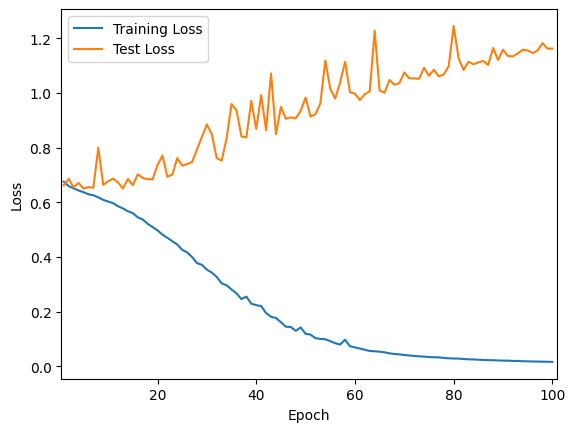

In [22]:
plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.plot(range(1, len(trainLossList) + 1), trainLossList)
plt.plot(range(1, len(testLossList) + 1), testLossList)
plt.xlim([0.5, nEpochs + 1])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Test Loss"], loc ="upper left")
plt.show()

##### Run `trainTestFCN_v2` using a fully connected neural network with an input layer of 3,072 neurons, three hidden layers of 1,024, 512, and 128 neurons respectively each with a `Tanh` activation function, and an output layer of 2 neurons with a `LogSoftmax` activation function.

In [23]:
torch.manual_seed(0)

nEpochs = 100
model = nn.Sequential(nn.Linear(3072, 1024),
                      nn.Tanh(),
                      nn.Linear(1024, 512),
                      nn.Tanh(),
                      nn.Linear(512, 128),
                      nn.Tanh(),
                      nn.Linear(128, 2),
                      nn.LogSoftmax(dim = 1)).to(device = device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
loss = nn.NLLLoss()
model, trainLossList, testLossList = trainTestFCN_v2(nEpochs = nEpochs, optimizer = optimizer, model = model, loss = loss)

Training and testing on a cuda device.

 Epoch 1:
    Training Loss = 0.672753
        Test Loss = 0.664968

 Epoch 2:
    Training Loss = 0.661604
        Test Loss = 0.659641

 Epoch 3:
    Training Loss = 0.657340
        Test Loss = 0.659656

...
...
...


 Epoch 98:
    Training Loss = 0.000825
        Test Loss = 2.127303

 Epoch 99:
    Training Loss = 0.000800
        Test Loss = 2.133171

 Epoch 100:
    Training Loss = 0.000771
        Test Loss = 2.181227

   Execution Time = 37.214583 seconds


##### Estimate the accuracy of the model on the training and test sets.

In [24]:
estimateAccuracyFCN(model = model)

Estimating accuracy on a cuda device.

Training Accuracy = 1.000000
    Test Accuracy = 0.615500


##### List the number of parameters the model has in each of its layers.

In [25]:
numelList = [p.numel() for p in model.parameters() if p.requires_grad == True]
numelList

[3145728, 1024, 524288, 512, 65536, 128, 256, 2]

##### Count the total number of parameters the model has.

In [26]:
sum(numelList)

3737474

##### Display how the values of the loss function change throughout the 100 epochs in the training and test sets.

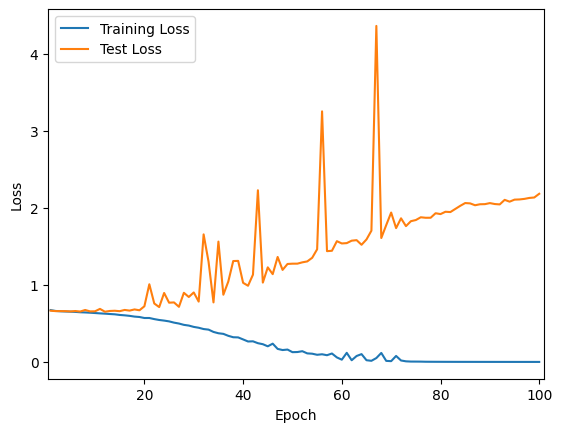

In [27]:
plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.plot(range(1, len(trainLossList) + 1), trainLossList)
plt.plot(range(1, len(testLossList) + 1), testLossList)
plt.xlim([0.5, nEpochs + 1])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Test Loss"], loc ="upper left")
plt.show()

##### Run `trainTestFCN_v2` using a neural network obtained by dropping the `LogSoftmax` activation function from the previous neural network and replacing the negative log-likelihood function with the cross-entropy loss function.

In [28]:
torch.manual_seed(0)

nEpochs = 100
model = nn.Sequential(nn.Linear(3072, 1024),
                      nn.Tanh(),
                      nn.Linear(1024, 512),
                      nn.Tanh(),
                      nn.Linear(512, 128),
                      nn.Tanh(),
                      nn.Linear(128, 2)).to(device = device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
loss = nn.CrossEntropyLoss()
model, trainLossList, testLossList = trainTestFCN_v2(nEpochs = nEpochs, optimizer = optimizer, model = model, loss = loss)

Training and testing on a cuda device.

 Epoch 1:
    Training Loss = 0.672753
        Test Loss = 0.664968

 Epoch 2:
    Training Loss = 0.661604
        Test Loss = 0.659641

 Epoch 3:
    Training Loss = 0.657340
        Test Loss = 0.659656

...
...
...


 Epoch 98:
    Training Loss = 0.000825
        Test Loss = 2.127303

 Epoch 99:
    Training Loss = 0.000800
        Test Loss = 2.133171

 Epoch 100:
    Training Loss = 0.000771
        Test Loss = 2.181227

   Execution Time = 36.908440 seconds


##### Note: Using the `LogSoftmax` activation function at the last layer of the neural network and the negative log-likelihood function as the loss function is equivalent to dropping the `LogSoftmax` activation function from the last layer and using the cross-entropy loss function.

$\hspace{1in}$

##### **Convolutional Neural Network**

##### Define a function that will be used to train and test a convolutional neural network. The following function is essentially the same as `trainTestFCN_v2`. The only difference is that in `trainTestCNN`, there is no need to reshape each minibatch before it is read by the neural network.

In [29]:
def trainTestCNN(nEpochs, optimizer, model, loss, displayEpochs = True):
    "Train and test a convolutional neural network."

    startTime = time.time()

    print(f"Training and testing on a {device} device.")

    trainLoader = torch.utils.data.DataLoader(cifar2TrainSet, batch_size = 64, shuffle = True)
    testLoader = torch.utils.data.DataLoader(cifar2TestSet, batch_size = 64, shuffle = True)

    trainLossList = []
    testLossList = []
    for epoch in range(1, nEpochs + 1):

        trainSumLoss = 0.0
        for images, labels in trainLoader:

            images = images.to(device = device)
            labels = labels.to(device = device)
            outputs = model(images)
            trainBatchLoss = loss(outputs, labels)

            optimizer.zero_grad()
            trainBatchLoss.backward()
            optimizer.step()
            trainSumLoss += trainBatchLoss.item()

        trainLoss = trainSumLoss/len(trainLoader)

        with torch.no_grad():

             testSumLoss = 0.0
             for images, labels in testLoader:

                 images = images.to(device = device)
                 labels = labels.to(device = device)
                 outputs = model(images)
                 testBatchLoss = loss(outputs, labels)
                 assert testBatchLoss.requires_grad == False
                 testSumLoss += testBatchLoss.item()

             testLoss = testSumLoss/len(testLoader)

        if displayEpochs:

           if epoch <= 3 or epoch >= nEpochs - 2:

              print('\n Epoch %d:' % epoch)
              print('    Training Loss = %f' % trainLoss)
              print('        Test Loss = %f' % testLoss)

           if epoch == 4:
              print('\n...\n...\n...\n')

        trainLossList.append(trainLoss)
        testLossList.append(testLoss)

    executionTime = time.time() - startTime

    if executionTime < 60:
       print("\n   Execution Time = %f seconds" % executionTime)
    else:
       print("\n   Execution Time = %f minutes" % (executionTime/60))

    return model, trainLossList, testLossList

##### Define a function that will be used to estimate the accuracy of a convolutional neural network.

In [30]:
def estimateAccuracyCNN(model):
    "Estimate the accuracy of a convolutional neural network on the training and test sets."

    print(f"Estimating accuracy on a {device} device.\n")

    trainLoader = torch.utils.data.DataLoader(cifar2TrainSet, batch_size = 64, shuffle = False)
    testLoader = torch.utils.data.DataLoader(cifar2TestSet, batch_size = 64, shuffle = False)

    for name, loader in [("Training", trainLoader), ("    Test", testLoader)]:

        correct = 0
        total = 0
        with torch.no_grad():

            for images, labels in loader:

                images = images.to(device = device)
                labels = labels.to(device = device)
                outputs = model(images)
                scores, predictions = torch.max(outputs, dim = 1)
                correct += int((predictions == labels).sum())
                total += labels.shape[0]

        print("%s Accuracy: %f" % (name, correct/total))

##### Run `trainTestCNN()` using a convolutional neural network with three modules in sequence. The first module has a convolutional layer with 3 input channels and 16 output channels, the `Tanh` activation function layer, and the `MaxPool2d` pooling layer. The second module has a convolutional layer with 16 input channels and 8 output channels, the `Tanh` activation function layer, and the `MaxPool2d` pooling layer. Both convolutional layers have kernel size = 3 and padding = 1. The third module forms a fully connected neural network with an input layer of 512 neurons, a hidden layer of 32 neurons with a `Tanh` activation function, and an output layer of 2 neurons.

In [31]:
torch.manual_seed(0)

nEpochs = 100
model = nn.Sequential(nn.Conv2d(3, 16, kernel_size = 3, padding = 1),
                      nn.Tanh(),
                      nn.MaxPool2d(2),
                      nn.Conv2d(16, 8, kernel_size = 3, padding = 1),
                      nn.Tanh(),
                      nn.MaxPool2d(2),
                      nn.Flatten(),
                      nn.Linear(8*8*8, 32),
                      nn.Tanh(),
                      nn.Linear(32, 2)).to(device = device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
loss = nn.CrossEntropyLoss()
model, trainLossList, testLossList = trainTestCNN(nEpochs = nEpochs, optimizer = optimizer, model = model, loss = loss)

Training and testing on a cuda device.

 Epoch 1:
    Training Loss = 0.692226
        Test Loss = 0.685804

 Epoch 2:
    Training Loss = 0.681519
        Test Loss = 0.677106

 Epoch 3:
    Training Loss = 0.675071
        Test Loss = 0.670130

...
...
...


 Epoch 98:
    Training Loss = 0.386316
        Test Loss = 0.578567

 Epoch 99:
    Training Loss = 0.384779
        Test Loss = 0.554177

 Epoch 100:
    Training Loss = 0.383141
        Test Loss = 0.548655

   Execution Time = 40.424917 seconds


##### Estimate the accuracy of the model on the training and test sets.

In [32]:
estimateAccuracyCNN(model = model)

Estimating accuracy on a cuda device.

Training Accuracy: 0.824400
    Test Accuracy: 0.728000


##### Display how the values of the loss function change throughout the 100 epochs in the training and test sets.

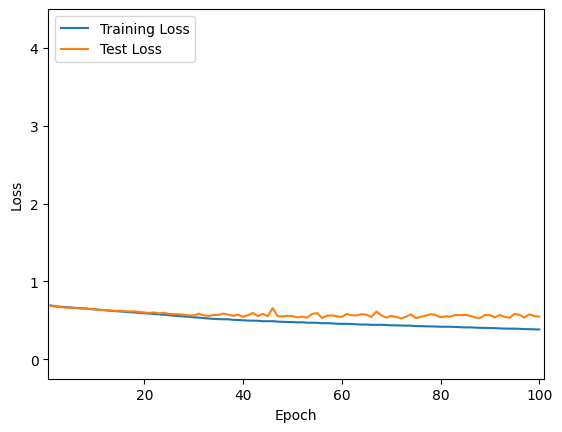

In [33]:
plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.plot(range(1, len(trainLossList) + 1), trainLossList)
plt.plot(range(1, len(testLossList) + 1), testLossList)
plt.yticks([0, 1, 2, 3, 4])
plt.xlim([0.5, nEpochs + 1])
plt.ylim([-0.25, 4.5])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Test Loss"], loc ="upper left")
plt.show()

##### List the number of parameters the model has in each of its layers.

In [34]:
numelList = [p.numel() for p in model.parameters() if p.requires_grad == True]
numelList

[432, 16, 1152, 8, 16384, 32, 64, 2]

##### Count the total number of parameters the model has.

In [35]:
sum(numelList)

18090

##### Write the previous convolutional neural network as a subclass of `nn.Module`.

In [36]:
class Net(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(512, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):

        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 512)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)

        return out

##### Run `trainTestCNN()` using an instance of the `Net` class.

In [37]:
torch.manual_seed(0)

nEpochs = 100
model = Net().to(device = device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
loss = nn.CrossEntropyLoss()
model, trainLossList, testLossList = trainTestCNN(nEpochs = nEpochs, optimizer = optimizer, model = model, loss = loss)

Training and testing on a cuda device.

 Epoch 1:
    Training Loss = 0.692226
        Test Loss = 0.685804

 Epoch 2:
    Training Loss = 0.681519
        Test Loss = 0.677106

 Epoch 3:
    Training Loss = 0.675070
        Test Loss = 0.670129

...
...
...


 Epoch 98:
    Training Loss = 0.386403
        Test Loss = 0.577191

 Epoch 99:
    Training Loss = 0.384758
        Test Loss = 0.553750

 Epoch 100:
    Training Loss = 0.383107
        Test Loss = 0.549069

   Execution Time = 41.177162 seconds


##### List the number of parameters the model has in each of its layers.

In [38]:
numelList = [p.numel() for p in model.parameters() if p.requires_grad == True]
numelList

[432, 16, 1152, 8, 16384, 32, 64, 2]

##### Count the total number of parameters the model has.

In [39]:
sum(numelList)

18090

##### The following class is a revision, which is called version 2 here, of the `Net` class. It uses the `torch.nn.functional` module, and makes the specification of the class more concise.

In [40]:
class Net_v2(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(512, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):

        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 512)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)

        return out

##### Run `trainTestCNN()` using an instance of the `Net_v2` class.

In [41]:
torch.manual_seed(0)

nEpochs = 100
model = Net_v2().to(device = device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
loss = nn.CrossEntropyLoss()
model, trainLossList, testLossList = trainTestCNN(nEpochs = nEpochs, optimizer = optimizer, model = model, loss = loss)

Training and testing on a cuda device.

 Epoch 1:
    Training Loss = 0.692226
        Test Loss = 0.685804

 Epoch 2:
    Training Loss = 0.681519
        Test Loss = 0.677106

 Epoch 3:
    Training Loss = 0.675070
        Test Loss = 0.670129

...
...
...


 Epoch 98:
    Training Loss = 0.386582
        Test Loss = 0.578795

 Epoch 99:
    Training Loss = 0.384960
        Test Loss = 0.554972

 Epoch 100:
    Training Loss = 0.383350
        Test Loss = 0.547846

   Execution Time = 40.206054 seconds


##### Note: The outputs of the preceding three runs of `trainTestCNN()` demonstrate that the definitions of the convolutional neural network using `nn.Sequential()`, `Net()`, and `Net_v2()` are equivalent.

##### Save the model defined by the `Net_v2` class.

In [42]:
torch.save(model.state_dict(), path + "cats_vs_dogs.pt")

##### Load the saved model.

In [43]:
loadedModel = Net_v2().to(device = device)
loadedModel.load_state_dict(torch.load(path + "cats_vs_dogs.pt", map_location = device))

<All keys matched successfully>

##### Check the loaded model by estimating the accuracy again on the training and test sets.

In [44]:
estimateAccuracyCNN(model = loadedModel)

Estimating accuracy on a cuda device.

Training Accuracy: 0.824500
    Test Accuracy: 0.729500
